In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import joblib
import json

from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [2]:
DATASET_DIR = "./dataset/"

images = []
labels = []
class_names = sorted(os.listdir(DATASET_DIR))

for label_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_DIR, class_name)
    for fname in os.listdir(class_dir):
        img_path = os.path.join(class_dir, fname)
        img = cv2.imread(img_path)

        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        images.append(img)
        labels.append(label_idx)

images = np.array(images)
labels = np.array(labels)

print("Dataset shape:", images.shape)


Dataset shape: (60, 224, 224)


In [3]:
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = "uniform"

In [4]:
features = []

for img in images:
    lbp = local_binary_pattern(
        img,
        P=LBP_POINTS,
        R=LBP_RADIUS,
        method=LBP_METHOD
    )

    hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, LBP_POINTS + 3),
        range=(0, LBP_POINTS + 2),
        density=True
    )

    features.append(hist)

X = np.array(features)
y = labels

print("Feature shape:", X.shape)


Feature shape: (60, 10)


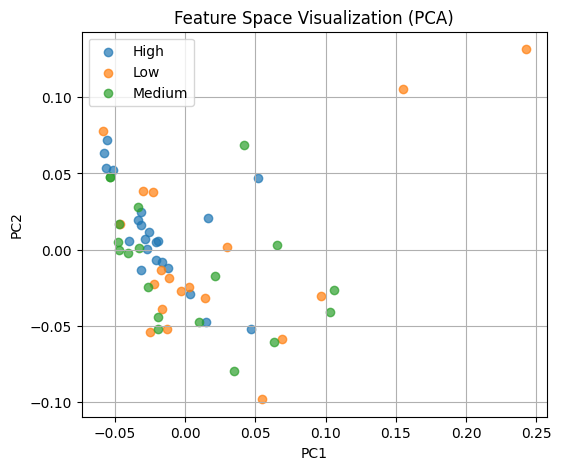

In [5]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
for i, name in enumerate(class_names):
    idx = y == i
    plt.scatter(
        X_2d[idx, 0],
        X_2d[idx, 1],
        label=name,
        alpha=0.7
    )

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Feature Space Visualization (PCA)")
plt.grid(True)
plt.show()


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=20,
    stratify=y
)

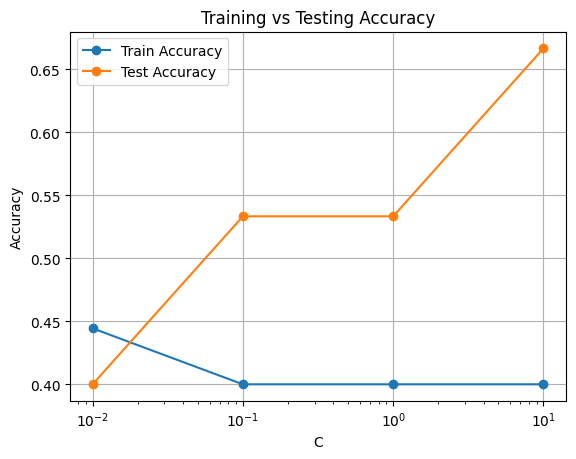

In [7]:
C_values = [0.01, 0.1, 1, 10]
train_acc = []
test_acc = []

for C in C_values:
    clf = LogisticRegression(
        max_iter=5000,
        C=C,
        class_weight="balanced"
    )
    clf.fit(X_train, y_train)

    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))


plt.figure()
plt.plot(C_values, train_acc, marker="o", label="Train Accuracy")
plt.plot(C_values, test_acc, marker="o", label="Test Accuracy")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
best_C = C_values[np.argmax(test_acc)]
print("Best C:", best_C)

final_clf = LogisticRegression(
    max_iter=5000,
    C=best_C,
    class_weight="balanced"
)
final_clf.fit(X_train, y_train)

y_pred = final_clf.predict(X_test)


Best C: 10


In [9]:
print(classification_report(
    y_test,
    y_pred,
    target_names=class_names
))

              precision    recall  f1-score   support

        High       0.62      1.00      0.77         5
         Low       0.67      0.40      0.50         5
      Medium       0.75      0.60      0.67         5

    accuracy                           0.67        15
   macro avg       0.68      0.67      0.65        15
weighted avg       0.68      0.67      0.65        15



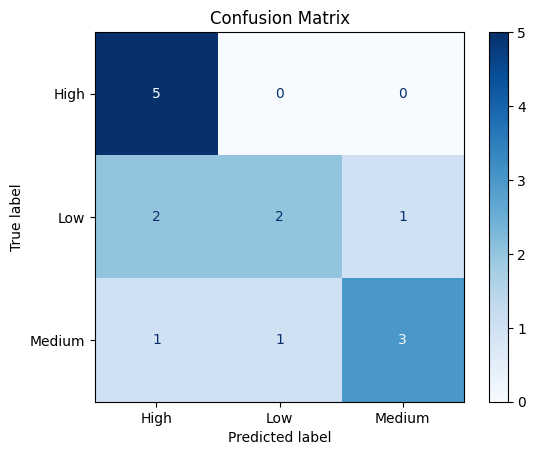

In [10]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

display.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [11]:
# save classifier
joblib.dump(final_clf, "crowd_classifier.pkl")

# save class names
with open("class_names.json", "w") as f:
    json.dump(class_names, f)